[Reference](https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f)

# Install & Import Dependencies

In [1]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
!pip install pandas
!pip install bs4

In [3]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Choose your desired Web Content, Scrape it and Save it into CSV format

In [4]:
url = "https://www.rigzone.com/news/what_could_omicron_cost_global_oil_market-03-dec-2021-167199-article"
# open the URL for reading
html = urllib.request.urlopen(url)
# parsing the html file
htmlParse = BeautifulSoup(html, 'html.parser')

parsed_text = ""

for para in htmlParse.find_all("p"):
    #parsed_text_str += str(para.get_text())
    parsed_text = " ".join((parsed_text, str(para.get_text())))
    
    
sentences = [[i] for i in nlp(parsed_text).sents]

In [5]:
parsed_text

"  \n var ssdl = ssdl || {}  \n ssdl.editorialMetaData = { 'Country' : 'All', \n'Region' : 'All', \n'company' : '', \n'sector' : 'Industry_Headlines', \n'industry_sector' : 'Downstream,Upstream', \n'audience' : 'News', \n'content_type' : 'About the Industry', \n'company_sentiment' : 'Negative', \n'author' : 'Andreas Exarheas', \n'published_date' : '2021-12-03', \n'tag' : 'People_on_the_Move,Govt_Regulatory,Political_Social_Unrest,Health_Safety_Environment,Analysis_Trends', \n'longevity' : 'News', \n'content_origin' : 'Original Content', \n} \n  The new Omicron variant of Covid-19 could cost the global oil market as much as 2.9 million barrels per day of demand in the first quarter of next year, bringing total demand down to 95.7 million barrels per day, if it triggers more lockdowns or restrictions. That’s according to Rystad Energy, which warned that, if the variant spreads rapidly, oil demand could fall by 1.3 million barrels per day, to 97.8 million barrels per day, in December 2021

In [6]:
myheaders = ['sentence']
myvalues = sentences
filename = 'article_text.csv'
with open(filename, 'w',newline='') as myfile:
    writer = csv.writer(myfile)
    writer.writerow(myheaders)
    writer.writerows(myvalues)

# Manually Clean Data (if necessary) & Re-Import the CSV File

In [7]:
# csv_sentences = pd.read_csv("article_text.csv")
csv_sentences = pd.read_csv("https://raw.githubusercontent.com/hamiasmaiX/web-relationextraction/main/article_text_clean.csv")

# Get entity pairs

In [8]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [10]:
entity_pairs = [] 
for i in tqdm(csv_sentences["sentence"]): 
    entity_pairs.append(get_entities(i))

100%|██████████| 32/32 [00:00<00:00, 77.33it/s]


# Get Relations for the entities

In [11]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [12]:
get_relation("John comnpleted the task")

'comnpleted'

In [13]:
relations = [get_relation(i) for i in tqdm(csv_sentences['sentence'])]

100%|██████████| 32/32 [00:00<00:00, 76.63it/s]


In [14]:
pd.Series(relations).value_counts()[:50]

announced                    2
added in                     2
is                           2
said in                      2
That                         2
Impact                       1
Cases                        1
warned                       1
cost                         1
fall by                      1
shows                        1
impacted                     1
“                            1
said                         1
fall to                      1
revealed                     1
noted                        1
\r\n                         1
reported to                  1
show                         1
see                          1
risen for                    1
been                         1
hope                         1
highlighted                  1
added                        1
admitted                     1
dtype: int64

# Display Entity Relations into Graphs

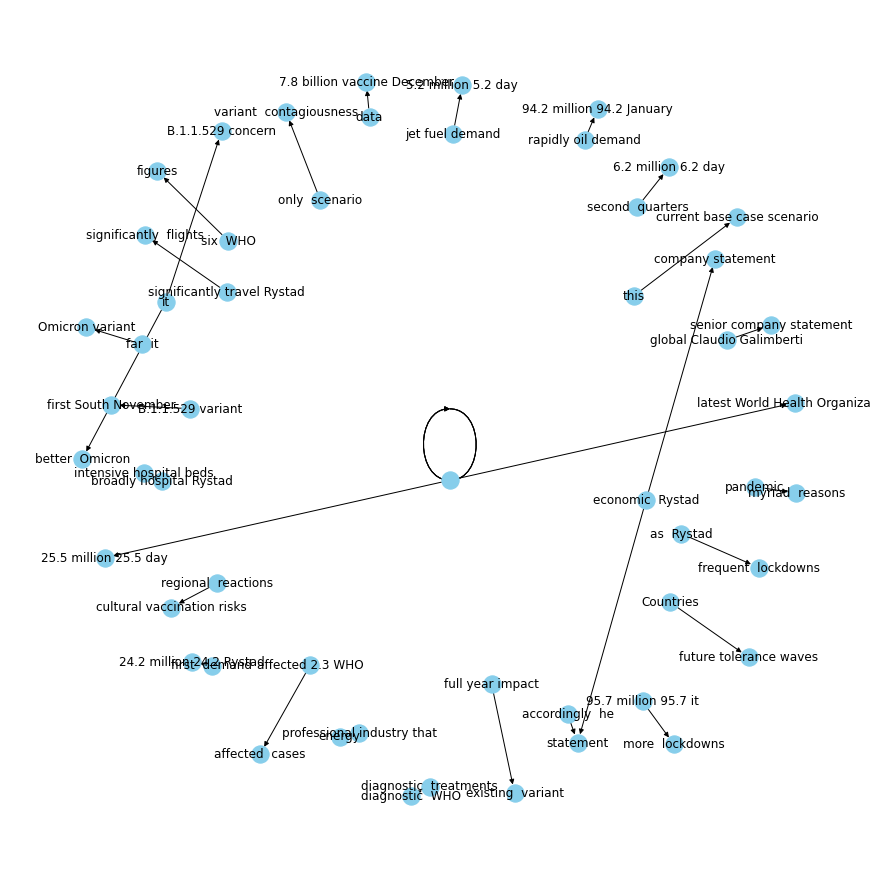

In [15]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

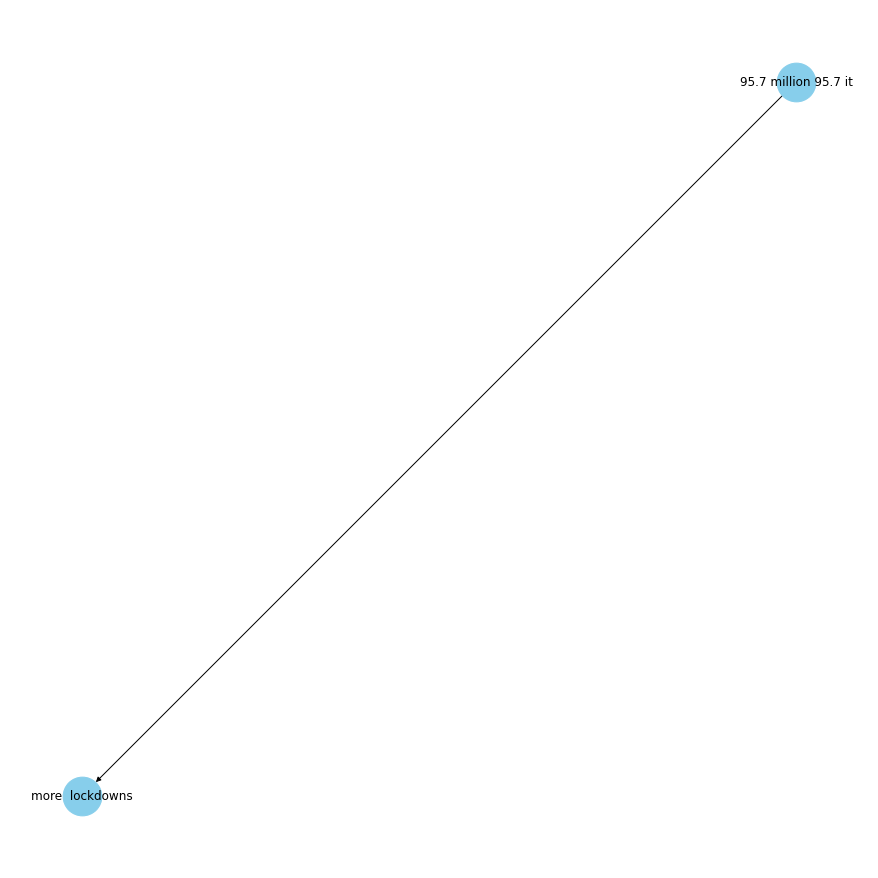

In [16]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="cost"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()